## imports

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os
import imageio
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import matplotlib.tri as mtri

In [2]:
from skfem import *
from skfem.helpers import dot, ddot, grad, sym_grad
from skfem.models.elasticity import linear_elasticity, linear_stress

In [3]:
from video_processing import get_first_frame
from utils import clip_value
from dat_reader import read_coordinates_table, read_connectivity_table

## Ravil's functions drawing and saving

In [4]:
_f = get_first_frame(pjoin('..','doc_2023-07-24_00-57-51.mp4'), 'sr.png')

In [27]:
# Define the colors for the gradient (blue -> yellow -> red)
# cmap_colors = [(0.0, 'blue'), (0.5, 'yellow'), (1.0, 'red')]
cmap_colors = [(0.0, '#000080'), (0.125, 'red'),  (0.375, 'yellow'), (0.625, 'cyan'), (0.875, 'blue'), (1.0, '#800000')]
# Create the custom colormap
deform_cmap = LinearSegmentedColormap.from_list('custom_gradient', cmap_colors)

In [28]:
mesh_name = None

In [71]:
mesh_name = 'nodes_1621_tria_3075_step_30_0'

In [72]:
assert mesh_name != None and mesh_name != ''

In [73]:
data_folder = pjoin('visualisation data', mesh_name)

In [74]:
tri_coord = np.load(pjoin(data_folder, 'coord.npy'))
E = np.load(pjoin(data_folder, 'e_xx.npy'))
node_coor = np.load(pjoin(data_folder, 'p1_xx_coord.npy'))

In [75]:
tri_coord.shape, E.shape, node_coor.shape

((153, 3075, 2), (153, 3075), (153, 1621, 2))

In [82]:
def visualisate_E_cv2_centers(coor, E, win_size = 15, video_in_path = None, video_out_path = None, glob_amp = None, skip_frames=0):
    if not os.path.exists('visual images'):
        os.makedirs('visual images')
    if not video_in_path:
        video_in_path = pjoin('..', 'Test1 - alecsandr27000.mkv')
    if not video_out_path:
        video_out_path = pjoin('visual images', 'visualisation_dots.mp4')

    total_frames = coor.shape[0]
    total_nodes = coor.shape[1]
    # print(total_frames, total_nodes)

    video_in = cv2.VideoCapture(video_in_path)
    _, frame = video_in.read()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(video_out_path, fourcc, 30.0, (frame.shape[1], frame.shape[0]))

    video_in = cv2.VideoCapture(video_in_path)
    for i in range(skip_frames):
        _, frame = video_in.read()

    amp = None
    if glob_amp:
        amp = np.max(np.abs(E)) if glob_amp < 0 else glob_amp

    circ_rad = int(round((frame.shape[1]* frame.shape[0]/(total_nodes*16))**0.5))
    # print(circ_rad)

    for i in tqdm(range(total_frames)):
        ret, frame = video_in.read()
        if not ret:
            break
        if not glob_amp:
            st_win = i
            end_win = i + win_size
            if i + win_size > total_frames:
                st_win = total_frames - win_size
                end_win = total_frames
            amp = np.max(np.abs(E[st_win:end_win]))
        # print(f'..{(st_win, end_win)}')
        # 0.5 * E[i] / amp + 0.5
        # plt.tricontourf(coor[i,:,0].flatten(), coor[i,:,1].flatten(), 0.5 * E[i] / amp + 0.5, cmap=deform_cmap)
        im_copy = frame.copy()
        for j in range(total_nodes):
            # print(j)
            new_val = clip_value(E[i,j], -amp, amp)
            cur_color = np.array(deform_cmap((new_val * 0.5 / amp + 0.5) * 0.9999)[2::-1]) * 255
            cur_color = tuple(map(int,cur_color))
            cv2.circle(im_copy, (int(coor[i,j,0]), int(coor[i,j,1])), circ_rad, color=cur_color, thickness=-1)  # Draw a red dot (BGR format) with radius 5
        # cv2.imwrite(pjoin('visual images', f'im_{i}.png'), im_copy)
        # cv2.imshow('im_window', im_copy)
        # plt.imshow(im_copy)
        video_out.write(im_copy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    video_in.release()
    video_out.release()

In [78]:
init_coord_table = np.load(pjoin(data_folder,'coord_table.npy'))
conn_table = np.load(pjoin(data_folder,'conn_table.npy'))

In [79]:
init_coord_table.shape, conn_table.shape

((1621, 3), (3075, 3))

In [80]:
def visualisate_E_cv2_triang(node_coor, conn_table, E, win_size = 15, video_in_path = None, video_out_path = None, glob_amp = None, skip_frames=0):
    if not os.path.exists('visual images'):
        os.makedirs('visual images')
    if not video_in_path:
        video_in_path = pjoin('..', 'Test1 - alecsandr27000.mkv')
    if not video_out_path:
        video_out_path = pjoin('visual images', 'visualisation_triang.mp4')

    total_frames = E.shape[0]
    total_centers = E.shape[1]
    # print(total_frames, total_centers)

    video_in = cv2.VideoCapture(video_in_path)
    _, frame = video_in.read()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(video_out_path, fourcc, 30.0, (frame.shape[1], frame.shape[0]))

    video_in = cv2.VideoCapture(video_in_path)
    for i in range(skip_frames):
        _, frame = video_in.read()

    amp = None
    if glob_amp:
        amp = np.max(np.abs(E)) if glob_amp < 0 else glob_amp

    for i in tqdm(range(total_frames)):
        ret, frame = video_in.read()
        if not ret:
            break
        if not glob_amp:
            st_win = i
            end_win = i + win_size
            if i + win_size > total_frames:
                st_win = total_frames - win_size
                end_win = total_frames
            amp = np.max(np.abs(E[st_win:end_win]))
        # 0.5 * E[i] / amp + 0.5
        im_copy = frame.copy()
        for j, tr in enumerate(conn_table):
            new_val = clip_value(E[i,j], -amp, amp)
            cur_color = np.array(deform_cmap((new_val * 0.5 / amp + 0.5) * 0.9999)[2::-1]) * 255
            cur_color = tuple(map(int,cur_color))

            tr_points = node_coor[i][tr]
            assert tr_points.shape[0] == 3, 'misshape'
            # print([np.round(tr_points).astype(int)])
            # print(cur_color)
            cv2.fillPoly(im_copy, [np.round(tr_points).astype(int)], cur_color)            

        # cv2.imwrite(pjoin('visual images', f'im_{i}.png'), im_copy)
        # cv2.imshow('im_window', im_copy)
        # plt.imshow(im_copy)
        video_out.write(im_copy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    video_in.release()
    video_out.release()

In [83]:
for glob_amp in [0.01, 0.03, 0.05]:
    visualisate_E_cv2_centers(node_coor, E, glob_amp=glob_amp, video_out_path = pjoin(data_folder, f'video_{glob_amp}.mp4'))
    visualisate_E_cv2_triang(node_coor, conn_table, E, glob_amp=glob_amp, video_out_path = pjoin(data_folder, f'video_tria_{glob_amp}.mp4'))

100%|██████████| 153/153 [00:50<00:00,  3.02it/s]


In [ ]:
# visualisate_E_cv2_triang(coord_for_ilsur_full, E_for_ravil_full, glob_amp=0.01, video_out_path = pjoin('visual images', 'vis_my_mesh_no_hole_tr.mp4'))

### try other functions

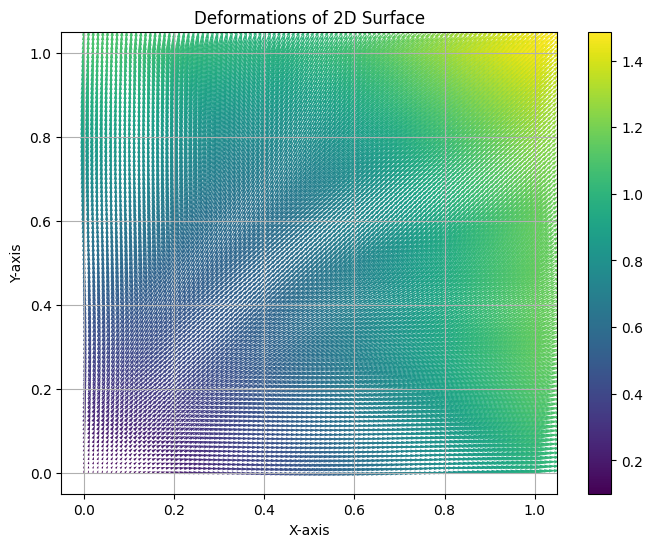

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid for the deformations (you can modify the size as needed)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Define the deformation field (you can modify this function based on your use case)
def deformation_field(x, y):
    return np.array([x + 0.1 * np.sin(2 * np.pi * y), y + 0.1 * np.cos(2 * np.pi * x)])

# Calculate the deformation vectors for each point in the grid
U, V = deformation_field(X, Y)

# Calculate the magnitude of the deformation vectors
magnitude = np.sqrt(U**2 + V**2)

# Create the plot with a gradient colormap
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, magnitude, cmap='viridis', scale=20)
plt.colorbar()

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Deformations of 2D Surface')
plt.grid(True)
plt.show()


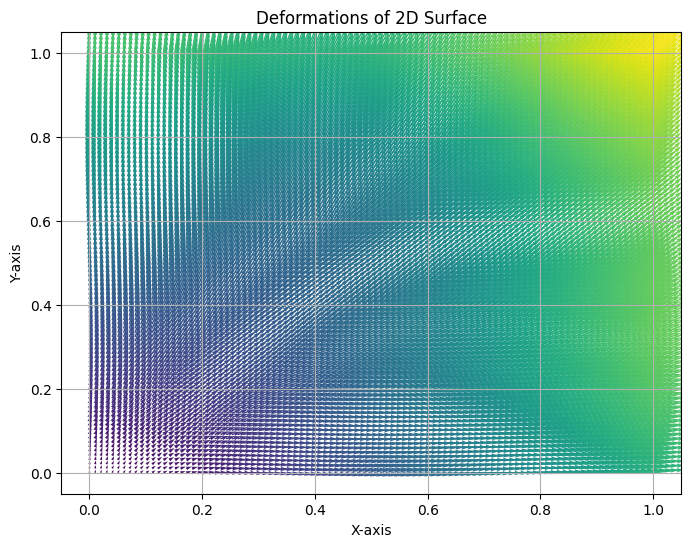

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid for the deformations (you can modify the size as needed)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
# определяет координаты точек (откуда начинаются стрелочки)
X, Y = np.meshgrid(x, y)

# Define the deformation field (you can modify this function based on your use case)
def deformation_field(x, y):
    return np.array([x + 0.1 * np.sin(2 * np.pi * y), y + 0.1 * np.cos(2 * np.pi * x)])

# Calculate the deformation vectors for each point in the grid
# Определяет направления стрелочек
U, V = deformation_field(X, Y)

# Calculate the magnitude of the deformation vectors
# Определяет цвет
magnitude = np.sqrt(U**2 + V**2)

# Create the plot with a gradient colormap
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, magnitude, cmap='viridis', scale=20)
plt.colorbar()

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Deformations of 2D Surface')
plt.grid(True)
plt.show()